(sec-dask-case-study)=
# Data Analysis with Dask

In this section, we will introduce two data analysis cases based on Dask.

In [1]:
import os

import matplotlib.pyplot as plt
%matplotlib inline
import dask.dataframe as dd
from dask.distributed import LocalCluster, Client
import pandas as pd

pd.options.mode.chained_assignment = None
# create a `LocalCluster` and connect
cluster = LocalCluster()
client = Client(cluster)

## Example: Citi Bike

The Citi Bike dataset provides detailed ride records of New York City's bike-sharing system. The dataset contains fields like ride ID, ride type, start and end times, start and end stations, latitude and longitude. This dataset can be utilized for analysis or visualization.

We start by reading the data. The Citi Bike dataset consists of multiple CSV files, with each file corresponding to a month. Dask can directly read multiple CSV files using the wildcard `*`.

In [2]:
import sys
sys.path.append("..")
from utils import citi_bike

bike_path = citi_bike()
ddf: dd.DataFrame = dd.read_csv(os.path.join(bike_path, "*.csv"))

ddf.head()

ride_id  rideable_type           started_at             ended_at  \
0  0905B18B365C9D20   classic_bike  2023-01-28 09:18:10  2023-01-28 09:28:52   
1  B4F0562B05CB5404  electric_bike  2023-01-23 20:10:12  2023-01-23 20:18:27   
2  5ABF032895F5D87E   classic_bike  2023-01-29 15:27:04  2023-01-29 15:32:38   
3  E7E1F9C53976D2F9   classic_bike  2023-01-24 18:35:08  2023-01-24 18:42:13   
4  323165780CA0734B   classic_bike  2023-01-21 20:44:09  2023-01-21 20:48:08   

                         start_station_name start_station_id  \
0  Hoboken Terminal - Hudson St & Hudson Pl            HB101   
1  Hoboken Terminal - Hudson St & Hudson Pl            HB101   
2  Hoboken Terminal - Hudson St & Hudson Pl            HB101   
3  Hoboken Terminal - Hudson St & Hudson Pl            HB101   
4                             Hamilton Park            JC009   

                             end_station_name end_station_id  start_lat  \
0                               Hamilton Park          JC009  40.735938   
1  Southwest Park - Jackson St & Observer Hwy          HB401  40.735938   
2                          Marshall St & 2 St          HB408  40.735944   
3                               Hamilton Park          JC009  40.735986   
4                                Manila & 1st          JC082  40.727596   

   start_lng    end_lat    end_lng member_casual  
0 -74.030305  40.727596 -74.044247        member  
1 -74.030305  40.737551 -74.041664        member  
2 -74.030383  40.740802 -74.042521        member  
3 -74.030364  40.727596 -74.044247        member  
4 -74.044247  40.721651 -74.042884        member

Next, we do some data preprocessing, which includes data transformation and data cleaning. Here, we use `map_partitions()` to process the data in each partition in parallel, calculating the average speed based on the latitude and longitude, start time, and end time of each ride.

In [3]:
def preprocess(df: dd.DataFrame):
    df["started_at"] = dd.to_datetime(df["started_at"], errors="coerce")
    df["ended_at"] = dd.to_datetime(df["ended_at"], errors="coerce")

    df["trip_duration"] = (df["ended_at"] - df["started_at"]).dt.total_seconds() / 60
    df = df[df["trip_duration"] > 0]

    df["year"] = df["started_at"].dt.year
    df["month"] = df["started_at"].dt.month
    df["day"] = df["started_at"].dt.day
    df["hour"] = df["started_at"].dt.hour

    # get the speed
    df["distance"] = (
        (df["end_lat"] - df["start_lat"]) ** 2 + (df["end_lng"] - df["start_lng"]) ** 2
    ) ** 0.5
    df["speed"] = df["distance"] / df["trip_duration"]

    df.dropna()
    return df


ddf = ddf.map_partitions(preprocess)
ddf.head()

/var/folders/4n/v40br47s46ggrjm9bdm64lwh0000gn/T/ipykernel_12300/3612891295.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/4n/v40br47s46ggrjm9bdm64lwh0000gn/T/ipykernel_12300/3612891295.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/4n/v40br47s46ggrjm9bdm64lwh0000gn/T/ipykernel_12300/3612891295.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

ride_id  rideable_type          started_at            ended_at  \
0  0905B18B365C9D20   classic_bike 2023-01-28 09:18:10 2023-01-28 09:28:52   
1  B4F0562B05CB5404  electric_bike 2023-01-23 20:10:12 2023-01-23 20:18:27   
2  5ABF032895F5D87E   classic_bike 2023-01-29 15:27:04 2023-01-29 15:32:38   
3  E7E1F9C53976D2F9   classic_bike 2023-01-24 18:35:08 2023-01-24 18:42:13   
4  323165780CA0734B   classic_bike 2023-01-21 20:44:09 2023-01-21 20:48:08   

                         start_station_name start_station_id  \
0  Hoboken Terminal - Hudson St & Hudson Pl            HB101   
1  Hoboken Terminal - Hudson St & Hudson Pl            HB101   
2  Hoboken Terminal - Hudson St & Hudson Pl            HB101   
3  Hoboken Terminal - Hudson St & Hudson Pl            HB101   
4                             Hamilton Park            JC009   

                             end_station_name end_station_id  start_lat  \
0                               Hamilton Park          JC009  40.735938   
1  Southwest Park - Jackson St & Observer Hwy          HB401  40.735938   
2                          Marshall St & 2 St          HB408  40.735944   
3                               Hamilton Park          JC009  40.735986   
4                                Manila & 1st          JC082  40.727596   

   start_lng    end_lat    end_lng member_casual  trip_duration  year  month  \
0 -74.030305  40.727596 -74.044247        member      10.700000  2023      1   
1 -74.030305  40.737551 -74.041664        member       8.250000  2023      1   
2 -74.030383  40.740802 -74.042521        member       5.566667  2023      1   
3 -74.030364  40.727596 -74.044247        member       7.083333  2023      1   
4 -74.044247  40.721651 -74.042884        member       3.983333  2023      1   

   day  hour  distance     speed  
0   28     9  0.016248  0.001518  
1   23    20  0.011473  0.001391  
2   29    15  0.013074  0.002349  
3   24    18  0.016222  0.002290  
4   21    20  0.006100  0.001531

Next, we visualize the average speed for different types of rides. Note that, due to Dask's lazy execution, you need to use `compute()` to trigger the computation.

/var/folders/4n/v40br47s46ggrjm9bdm64lwh0000gn/T/ipykernel_12300/3612891295.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/4n/v40br47s46ggrjm9bdm64lwh0000gn/T/ipykernel_12300/3612891295.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/4n/v40br47s46ggrjm9bdm64lwh0000gn/T/ipykernel_12300/3612891295.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

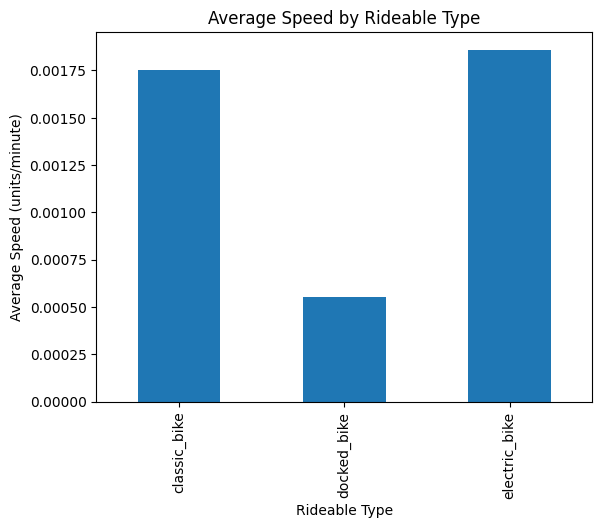

In [4]:
avg_speed_by_type = ddf.groupby('rideable_type')['speed'].mean().compute()
avg_speed_by_type.plot(kind='bar', title='Average Speed by Rideable Type')
plt.xlabel('Rideable Type')
plt.ylabel('Average Speed (units/minute)')
plt.show()

Next, we use `groupby()` to group the data and perform operations such as `count()`, `sort_values()`, and `mean()` to process the data.

In [5]:
def process_data(df: dd.DataFrame):
    # total rides that groupby start station
    total_rides_by_start_station = (
        df.groupby("start_station_name")["ride_id"].count().compute()
    )
    print("Total rides groupby start stations:")
    print(total_rides_by_start_station.head())

    # sort
    sorted_trips_by_start_station = total_rides_by_start_station.sort_values(
        ascending=False
    )
    print("\nSorted rides groupby start stations:")
    print(sorted_trips_by_start_station.head())

    # Average duration groupby month and rideable_type
    trip_duration_by_member_and_month = (
        df.groupby(["month", "rideable_type"])["trip_duration"].mean().compute()
    )
    print("\nAverage duration groupby `month` and `rideable_type`:")
    print(trip_duration_by_member_and_month)

    return trip_duration_by_member_and_month


trip_duration_by_member_and_month = process_data(ddf)

/var/folders/4n/v40br47s46ggrjm9bdm64lwh0000gn/T/ipykernel_12300/3612891295.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/4n/v40br47s46ggrjm9bdm64lwh0000gn/T/ipykernel_12300/3612891295.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/4n/v40br47s46ggrjm9bdm64lwh0000gn/T/ipykernel_12300/3612891295.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Total rides groupby start stations:
start_station_name
11 St & Washington St                4688
12 St & Sinatra Dr N                 3334
14 St Ferry - 14 St & Shipyard Ln    4100
4 St & Grand St                      2826
5 Corners Library                     938
Name: ride_id, dtype: int64

Sorted rides groupby start stations:
start_station_name
Grove St PATH                                   12649
Hoboken Terminal - River St & Hudson Pl         12151
South Waterfront Walkway - Sinatra Dr & 1 St     8509
Hoboken Terminal - Hudson St & Hudson Pl         7281
City Hall - Washington St & 1 St                 6503
Name: ride_id, dtype: int64

Average duration groupby `month` and `rideable_type`:
month  rideable_type
1      classic_bike      10.560105
       docked_bike      134.876000
       electric_bike     15.283021
2      classic_bike       9.565480
       docked_bike      192.740067
       electric_bike     11.009021
3      classic_bike      10.081960
       docked_bike      105.768

/var/folders/4n/v40br47s46ggrjm9bdm64lwh0000gn/T/ipykernel_12300/3612891295.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/4n/v40br47s46ggrjm9bdm64lwh0000gn/T/ipykernel_12300/3612891295.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/4n/v40br47s46ggrjm9bdm64lwh0000gn/T/ipykernel_12300/3612891295.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

下面我们对按月份和骑行类型分组的平均行程时长进行可视化。

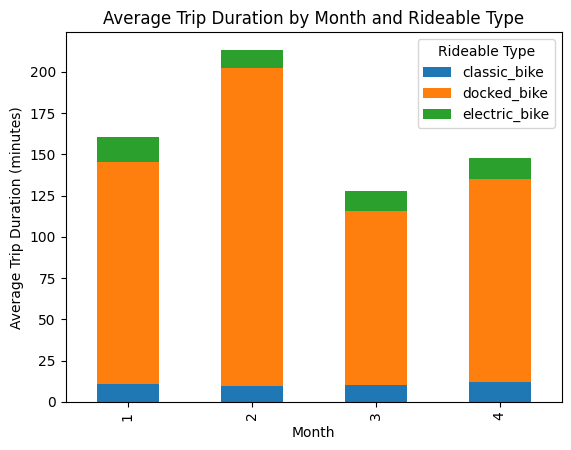

In [6]:
def plot_data(df):
    df.unstack().plot(kind="bar", stacked=True)
    plt.title("Average Trip Duration by Month and Rideable Type")
    plt.xlabel("Month")
    plt.ylabel("Average Trip Duration (minutes)")
    plt.legend(title="Rideable Type")
    plt.show()


plot_data(trip_duration_by_member_and_month)

We then attempt to add new data, using `concat()` for data merging and concatenation.

In [7]:
from utils import more_citi_bike

bike_path2 = more_citi_bike()
ddf2: dd.DataFrame = dd.read_csv(os.path.join(bike_path2, "*.csv"))

ddf2 = ddf2.map_partitions(preprocess)

concatenated_ddf = dd.concat([ddf, ddf2], axis=0)

trip_duration_by_member_and_month2 = process_data(concatenated_ddf)

/var/folders/4n/v40br47s46ggrjm9bdm64lwh0000gn/T/ipykernel_12300/3612891295.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/4n/v40br47s46ggrjm9bdm64lwh0000gn/T/ipykernel_12300/3612891295.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/4n/v40br47s46ggrjm9bdm64lwh0000gn/T/ipykernel_12300/3612891295.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Total rides groupby start stations:
start_station_name
11 St & Washington St                9190
12 St & Sinatra Dr N                 6934
14 St Ferry - 14 St & Shipyard Ln    7830
4 St & Grand St                      5703
5 Corners Library                    1745
Name: ride_id, dtype: int64

Sorted rides groupby start stations:
start_station_name
Hoboken Terminal - River St & Hudson Pl         23356
Grove St PATH                                   23034
Hoboken Terminal - Hudson St & Hudson Pl        13792
South Waterfront Walkway - Sinatra Dr & 1 St    13727
City Hall - Washington St & 1 St                11791
Name: ride_id, dtype: int64


/var/folders/4n/v40br47s46ggrjm9bdm64lwh0000gn/T/ipykernel_12300/3612891295.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/4n/v40br47s46ggrjm9bdm64lwh0000gn/T/ipykernel_12300/3612891295.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/4n/v40br47s46ggrjm9bdm64lwh0000gn/T/ipykernel_12300/3612891295.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum


Average duration groupby `month` and `rideable_type`:
month  rideable_type
1      classic_bike      10.560105
       docked_bike      134.876000
       electric_bike     15.283021
2      classic_bike       9.565480
       docked_bike      192.740067
       electric_bike     11.009021
3      classic_bike      10.081960
       docked_bike      105.768713
       electric_bike     12.169278
4      classic_bike      12.316335
       docked_bike      122.971542
       electric_bike     12.398595
10     classic_bike      11.750429
       electric_bike     16.112951
11     classic_bike       9.647373
       electric_bike     10.886656
12     classic_bike       9.715068
       electric_bike     10.103621
Name: trip_duration, dtype: float64


/var/folders/4n/v40br47s46ggrjm9bdm64lwh0000gn/T/ipykernel_12300/3612891295.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/4n/v40br47s46ggrjm9bdm64lwh0000gn/T/ipykernel_12300/3612891295.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/4n/v40br47s46ggrjm9bdm64lwh0000gn/T/ipykernel_12300/3612891295.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Visualize it:

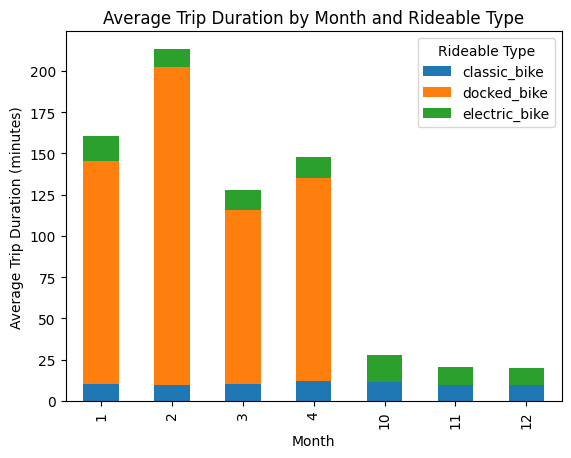

In [8]:
plot_data(trip_duration_by_member_and_month2)

Finally, we attempt to create a pivot table and visualize it.

/var/folders/4n/v40br47s46ggrjm9bdm64lwh0000gn/T/ipykernel_12300/3612891295.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/4n/v40br47s46ggrjm9bdm64lwh0000gn/T/ipykernel_12300/3612891295.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/4n/v40br47s46ggrjm9bdm64lwh0000gn/T/ipykernel_12300/3612891295.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

Pivot table:
rideable_type                      classic_bike  docked_bike  electric_bike
start_station_name                                                         
11 Ave & W 27 St                      16.583333          NaN            NaN
11 St & Washington St                  9.993954    20.685897       9.397788
12 St & Sinatra Dr N                  14.230417    38.415351      13.857875
14 St Ferry - 14 St & Shipyard Ln     13.091936   198.055702      15.262149
2 Ave & E 29 St                        7.983333          NaN            NaN
...                                         ...          ...            ...
Warren St                             10.612448    52.636364      11.075977
Washington St                         12.518832   130.303125      11.796525
Washington St & Gansevoort St          3.750000          NaN            NaN
Willow Ave & 12 St                    10.836851    20.166667      11.164558
York St & Marin Blvd                  11.622333    54.966667      25.448760

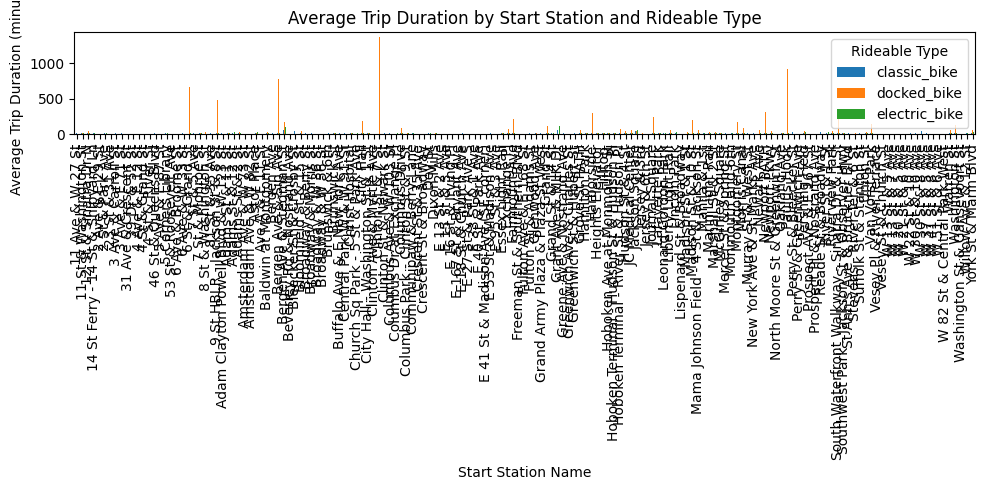

In [9]:
# convert 'rideable_type' into category
concatenated_ddf["rideable_type"] = concatenated_ddf["rideable_type"].astype("category")
concatenated_ddf = concatenated_ddf.categorize(columns=["rideable_type"])

# pivot table
pivot_table = concatenated_ddf.pivot_table(
    index="start_station_name",
    columns="rideable_type",
    values="trip_duration",
    aggfunc="mean",
).compute()

print("Pivot table:")
print(pivot_table)

# visualize it
pivot_table.plot(kind="bar", figsize=(10, 5))
plt.title("Average Trip Duration by Start Station and Rideable Type")
plt.xlabel("Start Station Name")
plt.ylabel("Average Trip Duration (minutes)")
plt.legend(title="Rideable Type")
plt.tight_layout()
plt.show()

## Example: Census Income

The adult dataset (also known as "Census Income" dataset) includes records of demographic information and income levels, including age, type of work, level of education, occupation, race, gender, weekly working hours, and income, etc.

We start by reading the data:

In [10]:
from utils import adult
import seaborn as sns

file_path = adult()
columns = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "income",
]
adult_ddf: dd.DataFrame = dd.read_csv(
    os.path.join(file_path, "adult.data"), names=columns, header=None
)

adult_ddf.head()

age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  income  
0          2174             0              40   United-States   <=50K  
1             0             0              13   United-States   <=50K  
2             0             0              40   United-States   <=50K  
3             0             0              40   United-States   <=50K  
4             0             0              40            Cuba   <=50K

Next, we preprocess the data.

In [11]:
categorical_columns = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native-country",
    "income",
]

numeric_columns = [
    "age",
    "fnlwgt",
    "education-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
]


def preprocess(ddf: dd.DataFrame):
    # convert to category
    for col in categorical_columns:
        ddf[col] = ddf[col].astype("category")

    return ddf.dropna()


adult_ddf = adult_ddf.map_partitions(preprocess)

adult_ddf.describe().compute()

age        fnlwgt  education-num  capital-gain  capital-loss  \
count  32561.000000  3.256100e+04   32561.000000  32561.000000  32561.000000   
mean      38.581647  1.897784e+05      10.080679   1077.648844     87.303830   
std       13.640433  1.055500e+05       2.572720   7385.292085    402.960219   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.178270e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.783560e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.370510e+05      12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       hours-per-week  
count    32561.000000  
mean        40.437456  
std         12.347429  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000

We draw a scatter plot to explore the relationship between income and other variables.

/Users/luweizheng/miniconda3/envs/dispy/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/luweizheng/miniconda3/envs/dispy/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/luweizheng/miniconda3/envs/dispy/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_

<Figure size 1000x1000 with 0 Axes>

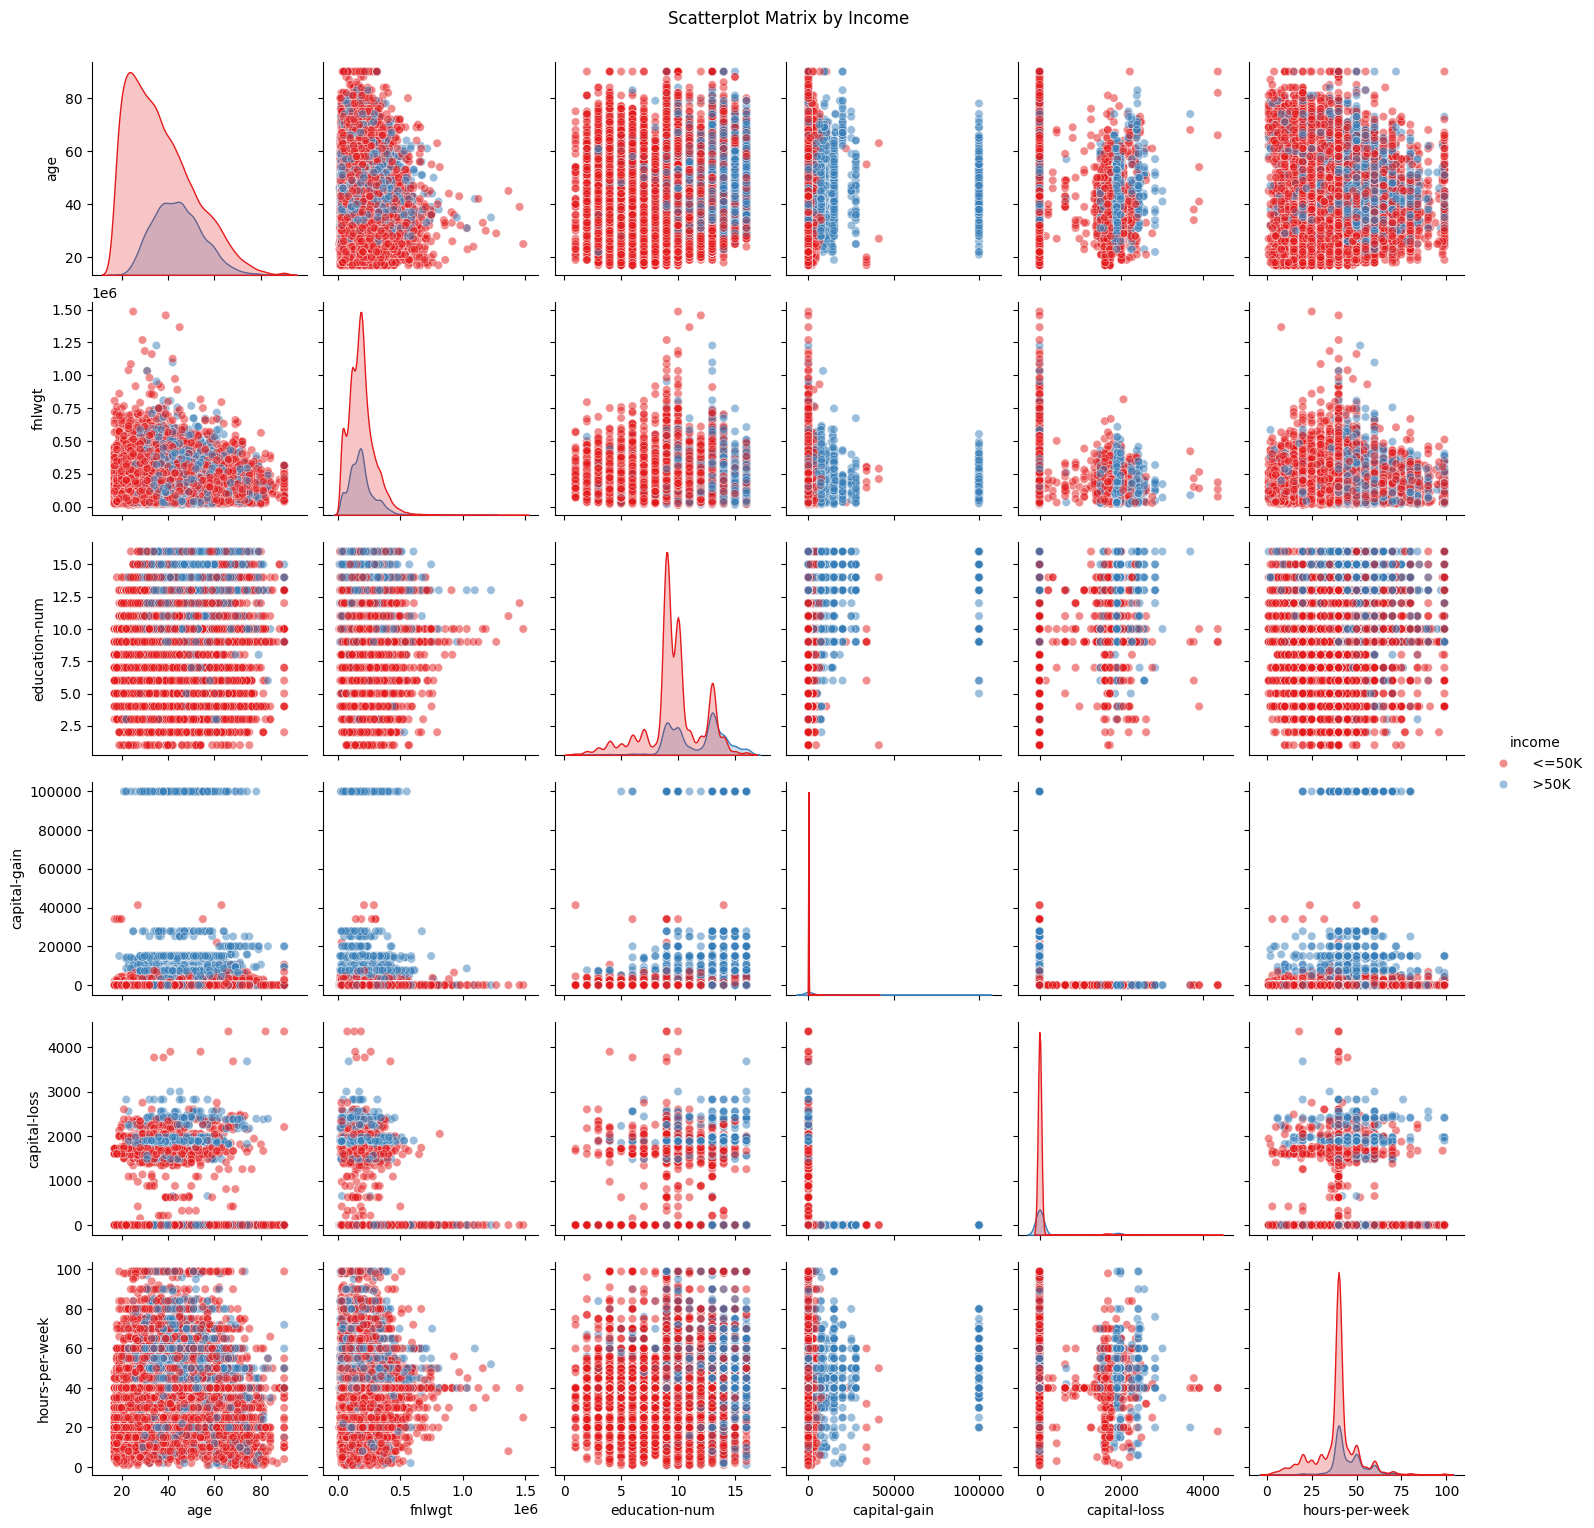

In [12]:
plt.figure(figsize=(10, 10))
sns.pairplot(
    adult_ddf.compute(),
    vars=numeric_columns,
    hue="income",
    palette="Set1",
    plot_kws={"alpha": 0.5},
)
plt.suptitle("Scatterplot Matrix by Income", y=1.02)
plt.show()

The results show that, except for `age`, the other factors do not significantly differ between incomes of `<=50k` and `>50k`. Therefore, we will next explore the relationship between age and income.

We use the `groupby()` function to investigate the differences in age and income under various levels of `education`.

/Users/luweizheng/miniconda3/envs/dispy/lib/python3.11/site-packages/dask_expr/_groupby.py:1542: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self._meta = self.obj._meta.groupby(
/Users/luweizheng/miniconda3/envs/dispy/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/luweizheng/miniconda3/envs/dispy/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  dat

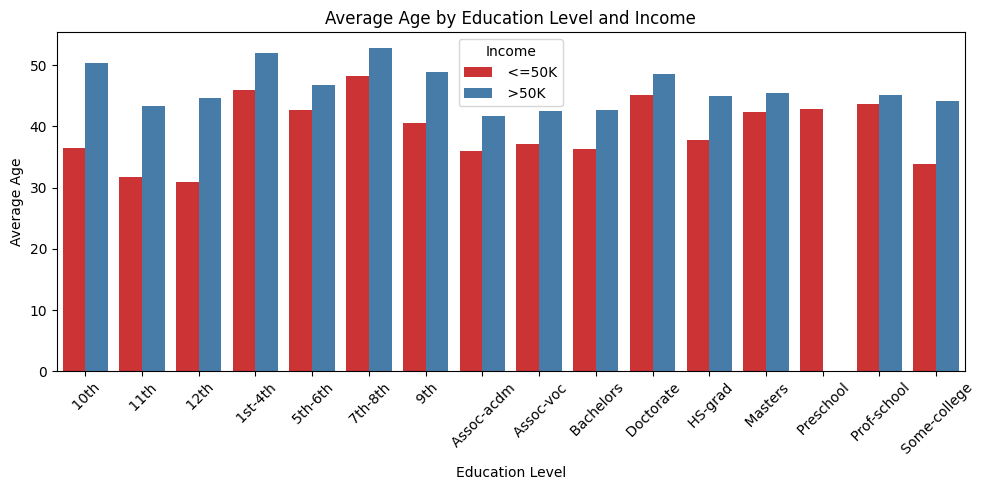

In [13]:
# groupby by `education` and `income`, get average age
education_income_age = (
    adult_ddf.groupby(["education", "income"])["age"].mean().reset_index().compute()
)

plt.figure(figsize=(10, 5))
sns.barplot(
    data=education_income_age, x="education", y="age", hue="income", palette="Set1"
)
plt.xticks(rotation=45)
plt.title("Average Age by Education Level and Income")
plt.xlabel("Education Level")
plt.ylabel("Average Age")
plt.legend(title="Income")
plt.tight_layout()
plt.show()

The results show that regardless of the level of education, the average age of people with an income of `>=50k` tends to be higher, mainly between the ages of 40 to 50. 

We wish to explore the relationship between age and income under more specific years of education `education_num`.

/Users/luweizheng/miniconda3/envs/dispy/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/luweizheng/miniconda3/envs/dispy/lib/python3.11/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Users/luweizheng/miniconda3/envs/dispy/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/luweizheng/miniconda3/envs/dispy/lib/python3.11/site-packag

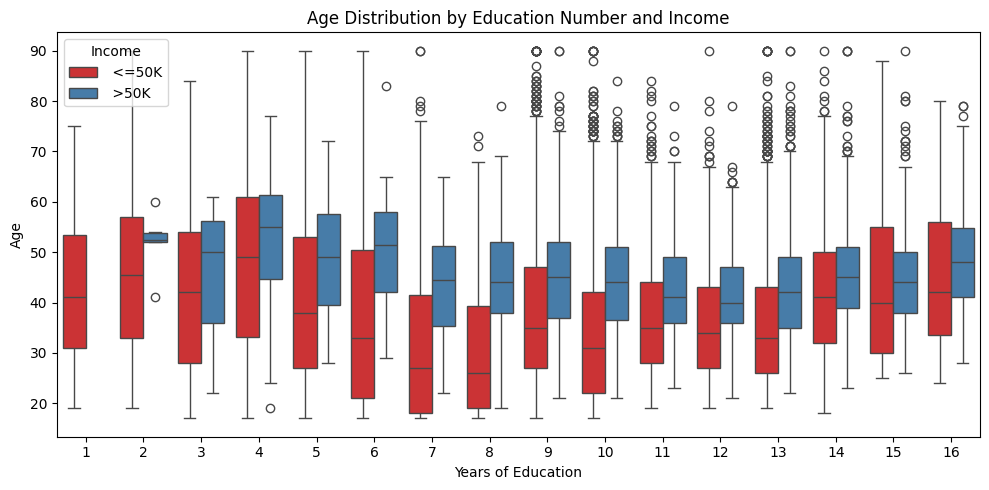

/Users/luweizheng/miniconda3/envs/dispy/lib/python3.11/site-packages/dask_expr/_groupby.py:1542: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self._meta = self.obj._meta.groupby(
/Users/luweizheng/miniconda3/envs/dispy/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/luweizheng/miniconda3/envs/dispy/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  dat

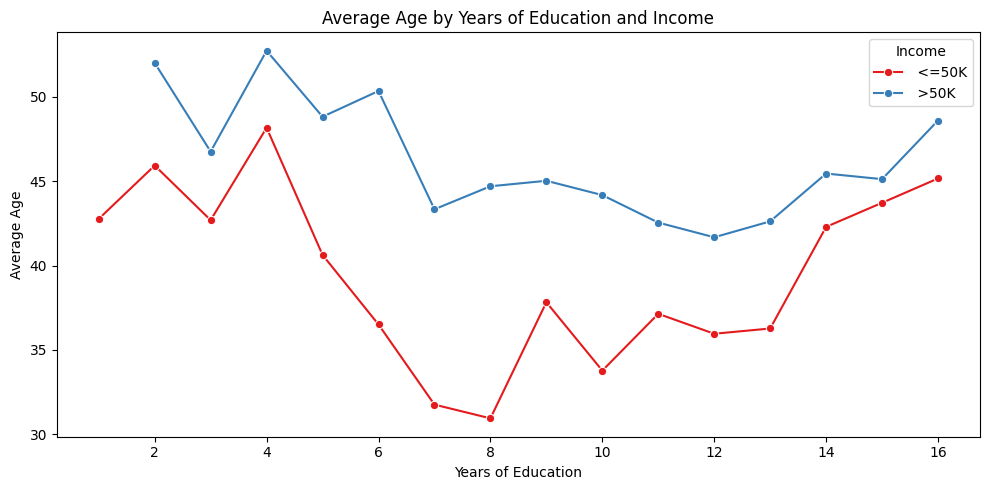

In [14]:
# relationship between `education-num` and `income`
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=adult_ddf.compute(), x="education-num", y="age", hue="income", palette="Set1"
)
plt.title("Age Distribution by Education Number and Income")
plt.xlabel("Years of Education")
plt.ylabel("Age")
plt.legend(title="Income")
plt.tight_layout()
plt.show()

# average age
education_num_income_age = (
    adult_ddf.groupby(["education-num", "income"])["age"].mean().reset_index().compute()
)

plt.figure(figsize=(10, 5))
sns.lineplot(
    data=education_num_income_age,
    x="education-num",
    y="age",
    hue="income",
    marker="o",
    palette="Set1",
)
plt.title("Average Age by Years of Education and Income")
plt.xlabel("Years of Education")
plt.ylabel("Average Age")
plt.legend(title="Income")
plt.tight_layout()
plt.show()

The results show that as the years of education increases, both the median age and mean age of individuals with an income `>50K` gradually increase, but the difference between the two groups decreases.

Finally, we examine the relationship between different levels of education and average hourly wage. We need to calculate the average hourly wage.

/Users/luweizheng/miniconda3/envs/dispy/lib/python3.11/site-packages/dask_expr/_groupby.py:1542: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self._meta = self.obj._meta.groupby(
/Users/luweizheng/miniconda3/envs/dispy/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/luweizheng/miniconda3/envs/dispy/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  dat

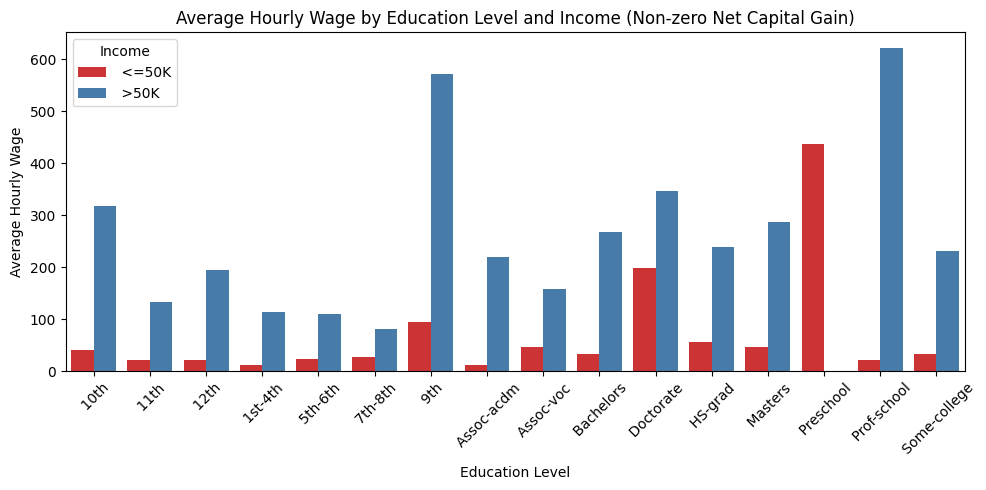

In [15]:
def calc_avg_income(df):
    df["net_capital_gain"] = df["capital-gain"] - adult_ddf["capital-loss"]
    df = df[df["net_capital_gain"] != 0]
    df["hourly_wage"] = df["net_capital_gain"] / df["hours-per-week"]

    return df


adult_ddf = calc_avg_income(adult_ddf)
# average hourly income
education_income_wage = (
    adult_ddf.groupby(["education", "income"])["hourly_wage"]
    .mean()
    .reset_index()
    .compute()
)

plt.figure(figsize=(10, 5))
sns.barplot(
    data=education_income_wage,
    x="education",
    y="hourly_wage",
    hue="income",
    palette="Set1",
)
plt.xticks(rotation=45)
plt.title(
    "Average Hourly Wage by Education Level and Income (Non-zero Net Capital Gain)"
)
plt.xlabel("Education Level")
plt.ylabel("Average Hourly Wage")
plt.legend(title="Income")
plt.tight_layout()
plt.show()

For lower levels of education, individuals with an income `>50K` have an average hourly wage that is significantly higher than those with an income `<=50K`. As the level of education increases, the gap in hourly wages between the `>50K` and `<=50K` income groups remains apparent, but in higher education levels, this gap is notably reduced. However, individuals with an income `>50K` still have a higher average hourly wage than those with an income `<=50K`.

Overall, the impact of education level on income is significant, with clear differences in average hourly wages among individuals of different education levels. Especially for individuals with an income `>50K`, their average hourly wage increases significantly with higher levels of education.

In [16]:
client.shutdown()